# Wrangling and Analyze WeRateDogs Twitter Data Archive

This project touches on data gathering, assesment, cleaning and analysis of WeRateDogs Twitter Archive. We shall also gather data provided by Udavity which uses AI to predict the breed of dogs in tweets using the pictures provided in those tweets. The main objective of this project to apply data wrangling techniques into making our datasets clean for analysis.

Data features for each dataset used in this project are as follows;  
**1. Twitter Archive:**  
   * `tweet_id`: This is unique value provided by twitter to uniquely identify tweets.
   * `in_reply_to_status_id`: This is unique value provided by twitter to uniquely identify RETWEETS.
   * `in_reply_to_user_id`: This is unique value provided by twitter to uniquely identify REPLIES.
   * `timestamp`: This contains time and date information on tweets.
   * `source`: This describes the platform used to make tweets, retweets or replies.
   * `text`: Contains the actual tweet made or posted on twitter.
   * `retweeted_status_timestamp`: This contains time and date information on retweets.
   * `expanded_urls`: Contains expanded/long-form links for tweets.
   * `rating_numerator`: Consist of the value given as the numerator while rating a dog.
   * `rating_denominator`: Consist of the value given as the denominator while rating a dog.
   * `doggo`: If the dog is a Doggo or not.
   * `floofer`: If the dog is a Floofer or not.
   * `pupper`: If the dog is a Pupper or not.
   * `puppo`: If the dog is a Puppo or not.  
    

**2. Tweet Image Prediction:**  
   * `tweet_id`: This is unique value provided by twitter to uniquely identify tweets.
   * `jpg_url`: Contains the URL link to the picture used for prediction/identification of breed.
   * `img_num`: Image number that corresponds to the most confident prediction. 1 to 4 since tweets can have up to four images
   * `p1`: is the algorithm's #1 prediction for the image in the tweet.
   * `p1_conf`: is how confident the algorithm is in its #1 prediction.
   * `p1_dog`: is whether or not the #1 prediction is a breed of dog.
   * `p2`: is the algorithm's #2 prediction for the image in the tweet.
   * `p2_conf`: is how confident the algorithm is in its #2 prediction.
   * `p2_dog`: is whether or not the #2 prediction is a breed of dog.
   * `p3`: is the algorithm's #3 prediction for the image in the tweet.
   * `p3_conf`: is how confident the algorithm is in its #3 prediction.
   * `p3_dog`: is whether or not the #3 prediction is a breed of dog.

**3. Tweet-JSON:**  
   * `id`: This is unique value provided by twitter to uniquely identify tweets.
   * `favorite_count`: Amount of favourites(likes) a tweet gets.
   * `retweet_count`: Amount of retweets a tweet gets.

In [1]:
import pandas as pd
import numpy as np
import tweepy
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re
import warnings
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# pd.options.display.max_columns = -1
pd.options.display.max_colwidth = -1
# pd.options.display.max_rows = -1 

warnings.filterwarnings('ignore')

plt.style.use('ggplot') 
%matplotlib inline

## Data Gathering

1. Read the Twitter Archive into pandas

In [3]:
# Load twitter archive data
archive = pd.read_csv('twitter_archive_enhanced.csv')

archive.shape

(2356, 17)

In [4]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
# request image prediction data
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
site = requests.get(url)

In [6]:
# write the image prediction content to a file
with open(url.split('/')[-1] , mode='wb') as file:
    file.write(site.content)

In [7]:
# load image data to pandas
image = pd.read_csv("image-predictions.tsv", sep='\t')
image.shape

(2075, 12)

In [8]:
image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [9]:
# read tweets json containing engagement data into a list
with open('tweet-json.txt') as file:
    status = []
    for line in file:
        status.append(json.loads(line))

In [10]:
engagement = pd.DataFrame(status)

In [11]:
engagement = engagement[['id', 'favorite_count', 'retweet_count']]
engagement.shape

(2354, 3)

In [12]:
engagement.head(3)

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328


## Assessing Data

In [13]:
print(image.tweet_id.nunique(), 'Unique image tweet id\n')

print(archive.tweet_id.nunique(), 'Unique Archive tweet id\n')

print(engagement.id.nunique(), 'Unique engagements tweet id')

2075 Unique image tweet id

2356 Unique Archive tweet id

2354 Unique engagements tweet id


In [14]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
image.nunique()

tweet_id    2075
jpg_url     2009
img_num     4   
p1          378 
p1_conf     2006
p1_dog      2   
p2          405 
p2_conf     2004
p2_dog      2   
p3          408 
p3_conf     2006
p3_dog      2   
dtype: int64

In [16]:
image.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
467,675047298674663426,https://pbs.twimg.com/media/CV4_8FgXAAQOj4S.jpg,1,Samoyed,0.978007,True,chow,0.007121,True,Pomeranian,0.006398,True
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
1887,847971574464610304,https://pbs.twimg.com/media/C8SZH1EWAAAIRRF.jpg,1,coffee_mug,0.633652,False,cup,0.273392,False,toilet_tissue,0.066656,False
974,706901761596989440,https://pbs.twimg.com/media/Cc9rZlBWwAA56Ra.jpg,1,wild_boar,0.859499,False,hog,0.128981,False,warthog,0.011318,False
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
173,669006782128353280,https://pbs.twimg.com/media/CUjKHs0WIAECWP3.jpg,1,Chihuahua,0.127178,True,Italian_greyhound,0.054215,True,pillow,0.048592,False
1006,709158332880297985,https://pbs.twimg.com/media/CddvvSwWoAUObQw.jpg,1,Siberian_husky,0.212957,True,Eskimo_dog,0.178887,True,Labrador_retriever,0.174218,True
877,698342080612007937,https://pbs.twimg.com/ext_tw_video_thumb/698341973569245184/pu/img/Sj3A2vSfbKWSv61T.jpg,1,boxer,0.883048,True,Saint_Bernard,0.030579,True,Staffordshire_bullterrier,0.012994,True
1217,743595368194129920,https://pbs.twimg.com/media/ClHICHmXEAI_1PS.jpg,1,hippopotamus,0.505675,False,hog,0.370726,False,warthog,0.018827,False
1709,818145370475810820,https://pbs.twimg.com/media/C1qi26rW8AMaj9K.jpg,1,golden_retriever,0.621931,True,Labrador_retriever,0.364997,True,redbone,0.003971,True


In [17]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [18]:
engagement.nunique()

id                2354
favorite_count    2007
retweet_count     1724
dtype: int64

In [19]:
engagement

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774
5,891087950875897856,20562,3261
6,890971913173991426,12041,2158
7,890729181411237888,56848,16716
8,890609185150312448,28226,4429
9,890240255349198849,32467,7711


In [20]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [21]:
archive.nunique()

tweet_id                      2356
in_reply_to_status_id         77  
in_reply_to_user_id           31  
timestamp                     2356
source                        4   
text                          2356
retweeted_status_id           181 
retweeted_status_user_id      25  
retweeted_status_timestamp    181 
expanded_urls                 2218
rating_numerator              40  
rating_denominator            18  
name                          957 
doggo                         2   
floofer                       2   
pupper                        2   
puppo                         2   
dtype: int64

In [22]:
archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1843,675853064436391936,NaN,NaN,2015-12-13 01:41:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/675853064436391936/photo/1,https://twitter.com/dog_rates/status/675853064436391936/photo/1",88,80,None,None,None,None,None
2063,671159727754231808,NaN,NaN,2015-11-30 02:52:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Anthony. He just finished up his masters at Harvard. Unprofessional tattoos. Always looks perturbed. 5/10 https://t.co/iHLo9rGay1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671159727754231808/photo/1,5,10,Anthony,None,None,None,None
780,775733305207554048,NaN,NaN,2016-09-13 16:30:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Anakin. He strives to reach his full doggo potential. Born with blurry tail tho. 11/10 would still pet well https://t.co/9CcBSxCXXG,NaN,NaN,NaN,https://twitter.com/dog_rates/status/775733305207554048/photo/1,11,10,Anakin,doggo,None,None,None
914,757393109802180609,NaN,NaN,2016-07-25 01:52:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo completely oblivious to the double rainbow behind him. 10/10 someone tell him https://t.co/OfvRoD6ndV,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/757393109802180609/photo/1,https://twitter.com/dog_rates/status/757393109802180609/photo/1,https://twitter.com/dog_rates/status/757393109802180609/photo/1,https://twitter.com/dog_rates/status/757393109802180609/photo/1",10,10,None,doggo,None,None,None
946,752568224206688256,NaN,NaN,2016-07-11 18:20:21 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Here are three doggos completely misjudging an airborne stick. Decent efforts tho. All 9/10 https://t.co/HCXQL4fGVZ,NaN,NaN,NaN,https://vine.co/v/5W0bdhEUUVT,9,10,None,None,None,None,None
1842,675870721063669760,6.757073e+17,4.196984e+09,2015-12-13 02:51:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",&amp; this is Yoshi. Another world record contender 11/10 (what the hell is happening why are there so many contenders?) https://t.co/QG708dDNH6,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675870721063669760/photo/1,11,10,None,None,None,None,None
1908,674436901579923456,NaN,NaN,2015-12-09 03:54:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Bailey. She plays with her food. Very childish. Doesn't even need a battle helmet smh. Still cute though. 9/10 https://t.co/CLEOjxhTEx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674436901579923456/photo/1,9,10,Bailey,None,None,None,None
885,760153949710192640,NaN,NaN,2016-08-01 16:43:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @hownottodraw: The story/person behind @dog_rates is heckin adorable af. 11/10, probably would pet. https://t.co/AG5UnRrmzJ",7.601538e+17,195036846.0,2016-08-01 16:42:51 +0000,"https://weratedogs.com/pages/about-us,https://weratedogs.com/pages/about-us",11,10,None,None,None,None,None
1304,707411934438625280,NaN,NaN,2016-03-09 03:45:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""I shall trip the big pupper with leash. Big pupper will never see it coming. I am a genius."" Both 11/10 https://t.co/uQsCJ8pf51",NaN,NaN,NaN,https://twitter.com/dog_rates/status/707411934438625280/photo/1,11,10,None,None,None,pupper,None
1222,714258258790387713,NaN,NaN,2016-0

In [23]:
# Tweets that are replies
archive[archive.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [24]:
# Tweets that are retweets
archive[archive.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" re

In [25]:
archive[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [26]:
archive.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [27]:
archive.name.value_counts().head()

None       745
a          55 
Charlie    12 
Oliver     11 
Lucy       11 
Name: name, dtype: int64

In [28]:
archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [29]:
archive[['doggo', 'floofer', 'pupper', 'puppo']].nunique()

doggo      2
floofer    2
pupper     2
puppo      2
dtype: int64

In [30]:
# sum the number of non-None values representing the type/decription of dog
(archive.query('doggo != "None"').shape[0] + 
 archive.query('floofer != "None"').shape[0] +
 archive.query('pupper != "None"').shape[0] + 
 archive.query('puppo != "None"').shape[0] )

394

### Quality issues

#### *Archive table*
1. Null values in in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.(Retweets and Replies)
2. tweet_id should be string.
3. timestamp in archive should be datetime.
4. Extreme and suspicious values in rating_numerator and rating_denominator columns.
5. Some ratings should be decimal.
6. missing names and weird names like a, an, the in name column.
7. missing description for dogs in doggo, floofer, pupper, puppo.
8. '\n' and "&amp ;" in text column.

#### *Image table*
1. Mix of lower or upper case letters at the start of names in p1, p2, p3.
2. tweet_id should be string.
3. Duplicates in jpg_url (these would be dropped during merge)


#### *Engagement table*
1. id should be string.

### Tidiness issues
1. Merge the 3 tables

2. Combine doggo, floofer, pupper and puppo from archive into 1 column. (archive table)

3. Combine P1_dog, P2_dog, P3_dog into one column. (image table)

4. Remove URL at the end of texts in archive dataframe.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [31]:
# Make copies of original pieces of data
archive_clean = archive.copy()
engagement_clean = engagement.copy()
image_clean = image.copy()

### #1: Null values in in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.(Retweets and Replies)

#### Define
remove non_null rows in the 5 columns, they represent Retweets and Replies which we do not need. Drop the 5 columns also.

#### Code

In [32]:
# remove rows that contain retweet and reply data
archive_clean = archive_clean.query('(in_reply_to_status_id != in_reply_to_status_id) and \
                                    (retweeted_status_id != retweeted_status_id)')

#### Test

In [33]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

###  #2: Remove null columns 

#### Define
We remove in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp columns from our archive_clean dataframe since they contain null values. Also remove columns not needed.

#### Code

In [34]:
to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id',
          'retweeted_status_timestamp', 'expanded_urls']

archive_clean.drop(to_drop, axis=1, inplace = True)

#### Test

In [35]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### #3: tweet_id should be string

#### Define
Change column type for tweet_id in archive_clean and image_clean tables, also for id column in engagements.  
Change timestamp column to datetime.

#### Code

In [36]:
# rename column in engagement table
engagement_clean.rename(columns={'id':'tweet_id'}, inplace=True)

In [37]:
# cahnge data type of columns
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype('str')

image_clean['tweet_id'] = image_clean['tweet_id'].astype('str')

engagement_clean['tweet_id'] = engagement_clean['tweet_id'].astype('str')

#### Test

In [38]:
archive_clean.dtypes

tweet_id              object        
timestamp             datetime64[ns]
text                  object        
rating_numerator      int64         
rating_denominator    int64         
name                  object        
doggo                 object        
floofer               object        
pupper                object        
puppo                 object        
dtype: object

In [39]:
image_clean.dtypes

tweet_id    object 
jpg_url     object 
img_num     int64  
p1          object 
p1_conf     float64
p1_dog      bool   
p2          object 
p2_conf     float64
p2_dog      bool   
p3          object 
p3_conf     float64
p3_dog      bool   
dtype: object

In [40]:
engagement_clean.dtypes

tweet_id          object
favorite_count    int64 
retweet_count     int64 
dtype: object

### #4: Combine doggo, floofer, pupper and puppo from archive into 1 column. (archive table)

#### Define
We shall concatanate the 4 columns which the describe the dogs into one column, with column name description.

#### Code

In [41]:
description = ['doggo', 'floofer', 'pupper', 'puppo']

# Make each word in the 4 columns begin with UpperCase
archive_clean[description] = archive_clean[description].apply(lambda row: row.str.title())

In [42]:
# Concatenate the values in the four columns into one column
archive_clean['description'] = archive_clean[description].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

# Drop the 4 columns that we concatenated
archive_clean.drop(description, axis=1, inplace = True)

In [43]:
# clean the description column created
archive_clean['description'] = archive_clean['description'].str.replace('None', '').replace('','None')

In [44]:
archive_clean['description'].unique()

array(['None', 'Doggo', 'Puppo', 'Pupper', 'Floofer', 'DoggoPuppo',
       'DoggoFloofer', 'DoggoPupper'], dtype=object)

In [45]:
# observe rows with more than one description
archive_clean[archive_clean['description'].isin(['DoggoPuppo','DoggoFloofer','DoggoPupper'])][['tweet_id', 'text', 'description']]

,tweet_id,text,description
191,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,DoggoPuppo
200,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",DoggoFloofer
460,817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",DoggoPupper
531,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,DoggoPupper
575,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,DoggoPupper
705,785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,DoggoPupper
733,781308096455073793,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",DoggoPupper
889,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",DoggoPupper
956,751583847268179968,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,DoggoPupper
1063,741067306818797568,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,DoggoPupper


In [46]:
archive_clean[archive_clean['description'].isin(['DoggoPuppo','DoggoFloofer','DoggoPupper'])].index.tolist()

[191, 200, 460, 531, 575, 705, 733, 889, 956, 1063, 1113]

In [47]:
# correct values in the description column 
archive_clean.loc[191,'description'] = archive_clean.loc[191,'description'][5:]
archive_clean.loc[200,'description'] = archive_clean.loc[200,'description'][5:]
archive_clean.loc[460,'description'] = archive_clean.loc[460,'description'][5:]
archive_clean.loc[531,'description'] = archive_clean.loc[531,'description'][5:]
archive_clean.loc[705,'description'] = archive_clean.loc[705,'description'][:5]
archive_clean.loc[956,'description'] = archive_clean.loc[956,'description'][5:]

#### Test

In [48]:
print(archive_clean.description.unique()) #the DoggoPupper row will be dropped later since it rates more than 1 dog
archive_clean.head(3)

['None' 'Doggo' 'Puppo' 'Pupper' 'Floofer' 'DoggoPupper']


,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,description
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None


### #5: missing names and weird names like a, an, the in name column.

#### Define
We replace name of dogs that make no sense with None in archive dataframe.

#### Code

In [49]:
# Observation above shows correct names start with upper case and wrong ones start with lower case
# extract rows where name string starts with lower case
wrong_names_df = archive_clean[archive_clean.name.apply(lambda name: name[0].islower())]

# observe wrong names list
print(wrong_names_df.name.value_counts().values.sum(), 'wrong names')
wrong_names_df.name.unique()

104 wrong names


array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my',
       'his', 'an', 'actually', 'just', 'getting', 'mad', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [50]:
# Replace values that match our wrong name list with 'None'
archive_clean['name'] = archive_clean['name'].apply(lambda name:'None' if name[0].islower() else name)

In [51]:
archive_clean[archive_clean.name.str.len() < 3]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,description
393,825876512159186944,2017-01-30 01:21:19,This is Mo. No one will push him around in the grocery cart. He's quite pupset about it. 11/10 I volunteer https://t.co/feNwTq12S5,11,10,Mo,None
449,819004803107983360,2017-01-11 02:15:36,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,14,10,Bo,Doggo
553,804026241225523202,2016-11-30 18:16:08,This is Bo. He's going to make me cry. 13/10 please get off the bus for him Carly https://t.co/U7FvBZo6Bq,13,10,Bo,None
679,789137962068021249,2016-10-20 16:15:26,This is Bo. He's a West Congolese Bugaboop Snuggle. Rather exotic. Master of the head tilt. 12/10 would pay to pet https://t.co/2jwxxtNzoN,12,10,Bo,None
775,776201521193218049,2016-09-14 23:30:38,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,10,10,O,None
820,770414278348247044,2016-08-30 00:14:12,Meet Al Cabone. He's a gangsta puppa. Rather h*ckin ruthless. Shows no mercy sometimes. 11/10 pet w extreme caution https://t.co/OUwWbEKOUV,11,10,Al,None
876,761004547850530816,2016-08-04 01:03:17,This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK,11,10,Bo,None
978,749996283729883136,2016-07-04 16:00:22,This is Bo. He emanates happiness. 12/10 I could cut the freedom with a knife https://t.co/c7LNFt39eR,12,10,Bo,None
1683,681694085539872773,2015-12-29 04:31:49,This is Bo. He's a Benedoop Cumbersnatch. Seems frustrated with own feet. Portable as hell. 11/10 very solid pupper https://t.co/TONMhRoQh7,11,10,Bo,Pupper
1988,672834301050937345,2015-12-04 17:46:12,"This is Ed. He's not mad, just disappointed. 10/10 https://t.co/BIljU0zhLN",10,10,Ed,None


In [52]:
#  visual observation shows we should correct names that are 'O' and 'Al'
archive_clean = archive_clean.replace({'name':{"O":"O'Malley", "Al":"Al Cabone"}})

#### Test

In [53]:
archive_clean['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela', 'Maya', 'Mingus',
       'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl', 'Lola',
       'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty', 'Gus',
       'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot', 'Louis',
       'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven', 'Beau',
       'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante', 'Nelly',
       'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash', 'Jed',
       'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford', 'Dewey',
       'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha', 'Lili',
       'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'Hobbes

### #6: '\n' and "&amp ;" in text column AND links at the end of strings in text column

#### Define
The text column in archuve dataframe contains links at the end of each text which we should remove. The text column also contains new line symbols(\n) and ampersand(&amp ;).

#### Code

In [54]:
# Replace incorrect strings in text
archive_clean['text'] = archive_clean.text.str.replace("&amp;", " & ").str.replace("\n", " ")
archive_clean['text'] = archive_clean.text.str.replace(r"http\S+", "").str.strip()

#### Test

In [55]:
archive_clean[archive_clean.text.str.contains(r"http\S+")]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,description


### #7: Mix of lower or upper case letters at the start of names in p1, p2, p3.

#### Define
Convert strings in columns p1, p2 and p3 to be uniform, making all the substrings lower case.

#### Code

In [56]:
# Edit breed names by removing the underscore
image_clean['p1'] = image_clean.p1.str.lower().str.replace('_', ' ').str.title()
image_clean['p2'] = image_clean.p2.str.lower().str.replace('_', ' ').str.title()
image_clean['p3'] = image_clean.p3.str.lower().str.replace('_', ' ').str.title()

#### Test

In [57]:
image_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
977,707038192327901184,https://pbs.twimg.com/media/Cc_ney1W4AANuY3.jpg,1,Pug,0.642426,True,Llama,0.057306,False,French Bulldog,0.054186,True
2050,887343217045368832,https://pbs.twimg.com/ext_tw_video_thumb/887343120832229379/pu/img/6HSuFrW1lzI_9Mht.jpg,1,Mexican Hairless,0.330741,True,Sea Lion,0.275645,False,Weimaraner,0.134203,True
769,689283819090870273,https://pbs.twimg.com/media/CZDT-mZWsAEK9BH.jpg,1,Scotch Terrier,0.267979,True,Affenpinscher,0.199619,True,Cairn,0.127469,True
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True
252,670717338665226240,https://pbs.twimg.com/media/CU7d2vKUcAAFZyI.jpg,1,Pomeranian,0.368161,True,Pekinese,0.350973,True,Golden Retriever,0.114902,True


In [58]:
image_clean.p1_dog.value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

### #8: Combine P1_dog, P2_dog, P3_dog into one column. (image table)

#### Define
We would combine all predictions and all confidence into 2 columns. We would only keep the values where we get the first x_dog column as True

#### Code

In [59]:
# create a function to extract dog type and confidence for the first 'True' prediction
def melt_predictions(image_clean):
    breed = []
    confidence = []
    if image_clean['p1_dog'] == True:
        breed.append(image_clean['p1'])
        confidence.append(image_clean['p1_conf'])
    elif image_clean['p2_dog'] == True:
        breed.append(image_clean['p2'])
        confidence.append(image_clean['p2_conf'])
    elif image_clean['p3_dog'] == True:
        breed.append(image_clean['p3'])
        confidence.append(image_clean['p3_conf'])
    else:
        breed.append('None')
        confidence.append('None')
    return breed[0], confidence[0]


In [60]:
# apply the function to out image table
predictions = image_clean.apply(melt_predictions, axis=1)

# Add the resulting single predictions to the image_clean dataframe
image_clean[['breed', 'confidence']] = pd.DataFrame(predictions.tolist(), index=image_clean.index)

In [61]:
# image_clean.query('p1_dog == False and breed =="None"')
image_clean.drop(image_clean.columns[3:-2], axis=1, inplace=True)

In [62]:
# Remove rows where we do not know the breed
image_clean = image_clean.query('breed != "None"')

#### Test

In [63]:
image_clean.shape

(1751, 5)

In [64]:
image_clean.sample(5)

,tweet_id,jpg_url,img_num,breed,confidence
548,677334615166730240,https://pbs.twimg.com/media/CWZgPPUWUAAUOvu.jpg,2,Lakeland Terrier,0.859392
977,707038192327901184,https://pbs.twimg.com/media/Cc_ney1W4AANuY3.jpg,1,Pug,0.642426
1243,747219827526344708,https://pbs.twimg.com/media/Cl6odlVWQAIy5uk.jpg,2,Shetland Sheepdog,0.548018
1022,710272297844797440,https://pbs.twimg.com/media/Cdtk414WoAIUG0v.jpg,1,Old English Sheepdog,0.586307
1541,791026214425268224,https://pbs.twimg.com/media/CpmyNumW8AAAJGj.jpg,1,Malamute,0.375098


### #9: Merge all data 3 dataframes

#### Define
we will combine the three tables into one

#### Code

In [65]:
archive_clean.shape

(2097, 7)

In [66]:
image_clean.shape

(1751, 5)

In [67]:
tweets = pd.merge(archive_clean, engagement_clean, on='tweet_id')

In [68]:
tweets = pd.merge(tweets, image_clean, on='tweet_id')

In [69]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1665
Data columns (total 13 columns):
tweet_id              1666 non-null object
timestamp             1666 non-null datetime64[ns]
text                  1666 non-null object
rating_numerator      1666 non-null int64
rating_denominator    1666 non-null int64
name                  1666 non-null object
description           1666 non-null object
favorite_count        1666 non-null int64
retweet_count         1666 non-null int64
jpg_url               1666 non-null object
img_num               1666 non-null int64
breed                 1666 non-null object
confidence            1666 non-null object
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 182.2+ KB


In [70]:
tweets.confidence = tweets.confidence.astype(float)

#### Test

In [71]:
tweets.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,description,favorite_count,retweet_count,jpg_url,img_num,breed,confidence
1460,670822709593571328,2015-11-29 04:32:51,Can't do better than this lol. 10/10 for the owner,10,10,None,None,647,105,https://pbs.twimg.com/media/CU89schWIAIHQmA.jpg,1,Chihuahua,0.001252
105,864279568663928832,2017-05-16 00:41:21,This is Meatball. He doing what's known in the industry as a mid-strut mlem. H*ckin fancy boy. 12/10 I'd do anything for Meatball,12,10,Meatball,None,15195,3266,https://pbs.twimg.com/media/C_6JrWZVwAAHhCD.jpg,1,Bull Mastiff,0.668613
1425,671896809300709376,2015-12-02 03:40:57,This is Lola. She fell asleep on a piece of pizza. 10/10 frighteningly relatable,10,10,Lola,None,9016,4519,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,Chow,0.243529
1295,675781562965868544,2015-12-12 20:57:34,Say hello to Buddah. He was Waldo for Halloween. 11/10,11,10,Buddah,None,1750,537,https://pbs.twimg.com/media/CWDbv2yU4AARfeH.jpg,1,Maltese Dog,0.921968
615,753026973505581056,2016-07-13 00:43:15,Say hello to Tayzie. She's a Barbadian Bugaboop. Seems quite social. A rare quality for a Bugaboop. 10/10 petable af,10,10,Tayzie,None,4283,1109,https://pbs.twimg.com/media/CnNKCKKWEAASCMI.jpg,3,Pembroke,0.868511


### #10: Extreme and suspicious values in rating_numerator and rating_denominator columns.

### Define
We shall investigate and correct numerator and denominator values that look extreme and replace them with their correct values. Some texts show that their ratings should be decimal.

#### Code

In [72]:
mask = tweets.text.str.contains(r"(\d+\.\d*\/\d+)")  # creates a boolean mask for texts that contain decimal ratings
tweets[mask][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
36,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5,10
450,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75,10
495,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27,10
1190,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26,10


In [73]:
idx = tweets[mask].index.tolist() # creates a list containing the index for the boolean mask
for i in idx:
    text = tweets.loc[i,'text'] 
    numerator = re.findall(r'\d+\.\d*\/\d+', text)[0].split('/')[0] # extract the numerator
    tweets.loc[i,'rating_numerator'] = int(round(float(numerator)))

In [74]:
# query for rating denominator that do not equal 10
tweets.query('rating_denominator != 10')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
289,The floofs have been released I repeat the floofs have been released. 84/70,84,70
345,Meet Sam. She smiles 24/7 & secretly aspires to be a reindeer. Keep Sam smiling by clicking and sharing this link:,24,7
589,Why does this never happen at my front door... 165/150,165,150
705,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11
786,Happy 4/20 from the squad! 13/10 for all,4,20
816,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50
835,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
854,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
871,"From left to right: Cletus, Jerome, Alejandro, Burp, & Titson None know where camera is. 45/50 would hug all at once",45,50
929,Here is a whole flock of puppers. 60/50 I'll take the lot,60,50


In [75]:
# query for rating denominator that do not equal 10 and match a regex pattern for texts that contain what looks like
# two ratings
tweets.query('rating_denominator != 10')[['text', 'rating_numerator', 'rating_denominator']][tweets.text.str.contains(r".*\d+\/\d+[^&]+\d+\/\d+")]

,text,rating_numerator,rating_denominator
705,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11
786,Happy 4/20 from the squad! 13/10 for all,4,20
816,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50
1156,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10,7,11
1648,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10,1,2


In [76]:
# correct the numerator and denominator values that match our regex
for index, row in tweets.query('rating_denominator != 10').iterrows():
    
    '''The regex pattern finds texts that contain what looks like two ratings 
    but do not have the ampersand substring between them'''
    
    if re.findall(r".*\d+\/\d+[^&]+\d+\/\d+",row.text):
        numerator = row.text.split('/')[1][-2:].strip()
        denominator = row.text.split('/')[2][:2]
        tweets.loc[index,'rating_numerator'] = int(numerator)
        tweets.loc[index,'rating_denominator'] = int(denominator)

In [77]:
# No rating in tweet as observed from the query above
tweets.drop([345], inplace=True)

In [78]:
tweets.query('rating_denominator != 10')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
289,The floofs have been released I repeat the floofs have been released. 84/70,84,70
589,Why does this never happen at my front door... 165/150,165,150
835,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
854,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
871,"From left to right: Cletus, Jerome, Alejandro, Burp, & Titson None know where camera is. 45/50 would hug all at once",45,50
929,Here is a whole flock of puppers. 60/50 I'll take the lot,60,50
994,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once,44,40
1133,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110,121,110
1241,IT'S PUPPERGEDDON. Total of 144/120 ...I think,144,120
1290,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once,88,80


In [79]:
# Drop rows where denominator not equal to 10, rating multiple dogs
tweets = tweets.query('rating_denominator == 10')

In [80]:
# matches tweets rating more than one dog
pattern = r"\d+\/\d+\s(and|&)\s\d+\/\d+"
tweets[tweets.text.str.contains(pattern)][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
497,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12,10
665,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10,10
934,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9,10
1282,These two pups just met and have instantly bonded. Spectacular scene. Mesmerizing af. 10/10 and 7/10 for blue dog,10,10
1484,Meet Hank and Sully. Hank is very proud of the pumpkin they found and Sully doesn't give a shit. 11/10 and 8/10,11,10
1557,This is Spark. He's nervous. Other dog hasn't moved in a while. Won't come when called. Doesn't fetch well 8/10 & 1/10,8,10
1598,Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10,7,10


In [81]:
# drop tweets with more than 1 rating
more1_rating = tweets[tweets.text.str.contains(pattern)].index.tolist()
tweets.drop(more1_rating, inplace=True)

#### Test

In [82]:
tweets[mask][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
36,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",14,10
450,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",10,10
495,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11,10
1190,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,11,10


In [83]:
tweets.query('rating_denominator != 10')[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator


In [84]:
tweets[tweets.text.str.contains(pattern)][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator


## Storing Data

In [85]:
tweets.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data

In [86]:
# create column with length of tweet texts
tweets['text_length'] = tweets.text.str.len()

# create date column to help with analysis
tweets['date'] = pd.to_numeric(tweets.timestamp)

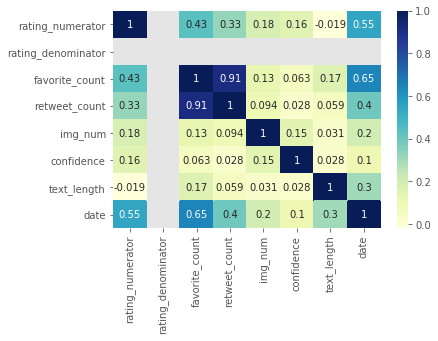

In [87]:
# heatmap for tweets correlation
sns.heatmap(tweets.corr(), cmap="YlGnBu", annot=True);

We can see from the chart that there seems to be correlation between some attributes of our data. The strongest correlation can be observed between favourite count and retweet counts.  
We can also see that the date column seems to have a relationship with the favourite count, rating numerator and to a much lesser extent retweet count and length of tweets. 

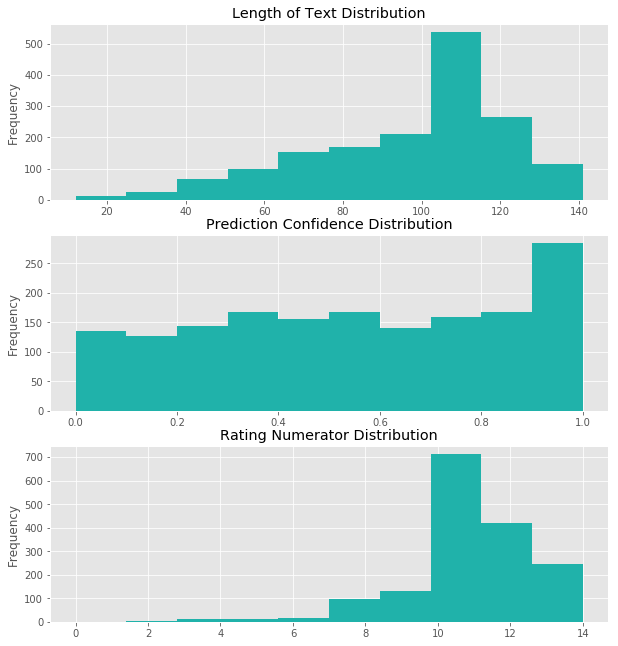

In [88]:
# Plotting histograms for Length texts, Confidence and Rating Numerator
fig, axes = plt.subplots(3,1, figsize=(10,11))

tweets.text_length.plot(kind='hist', by='breed',color="lightseagreen", title="Length of Text Distribution", ax=axes[0])

tweets.confidence.plot(kind='hist',color="lightseagreen", title="Prediction Confidence Distribution", ax=axes[1])

tweets.rating_numerator.plot(kind='hist',color="lightseagreen", title="Rating Numerator Distribution", ax=axes[2]);

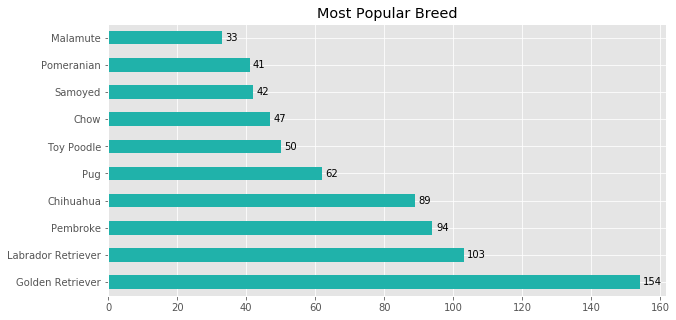

In [89]:
# Plot Bar chart for Breeds
tweets.breed.value_counts()[:10].plot(kind='barh', color='lightseagreen', figsize=(10,5),
                                     title = 'Most Popular Breed');

x = tweets['breed'].value_counts()[:10].values
y = np.arange(0,10,1)

# Add text value for each breed:
for xx, yy in zip(x,y):
    plt.text(xx+1, yy, xx, va='center')

In [90]:
# group by breeds
breed_df = tweets.groupby('breed').agg( {'rating_numerator': ['count', 'mean'],
                                  'favorite_count': ['mean','sum'],
                                  'retweet_count': ['mean', 'sum']})

# Rename columns
breed_df.columns = breed_df.columns.set_levels(['rating', 'favourite', 'retweet'], level=0)
breed_df.columns = breed_df.columns.set_levels(['frequency', 'mean', 'total'], level=1)

# Round values to two decimal places
breed_df = breed_df.round({ ('rating','mean'):2, ('favourite','mean'):2, ('retweet','mean'):2})

breed_df

rating        favourite          retweet  \
                               frequency   mean      mean   total     mean   
breed                                                                        
Afghan Hound                    3         9.67   17326.67  51980   5976.00   
Airedale                        12        9.83   5280.83   63370   1393.75   
American Staffordshire Terrier  16        10.31  9380.19   150083  2310.81   
Appenzeller                     2         11.00  7317.50   14635   1458.00   
Australian Terrier              2         11.50  11127.50  22255   3078.50   
Basenji                         9         10.33  2503.78   22534   890.11    
Basset                          17        10.71  11762.06  199955  2915.47   
Beagle                          20        10.15  4407.95   88159   1352.50   
Bedlington Terrier              6         10.33  21153.17  126919  7510.17   
Bernese Mountain Dog            11        11.27  7284.00   80124   1616.55   
Black-And-Tan Coonhound         2         10.50  17012.00  34024   4164.50   
Blenheim Spaniel                10        11.10  9280.90   92809   2583.30   
Bloodhound                      7         10.43  11080.29  77562   2499.86   
Bluetick                        4         10.50  5034.50   20138   1504.25   
Border Collie                   11        10.73  9555.64   105112  2369.45   
Border Terrier                  7         12.14  13578.00  95046   3377.14   
Borzoi                          8         10.50  6321.75   50574   1845.50   
Boston Bull                     12        9.42   5289.58   63475   1446.92   
Bouvier Des Flandres            1         13.00  18032.00  18032   4479.00   
Boxer                           11        10.55  8652.09   95173   2579.91   
Brabancon Griffon               3         10.00  885.00    2655    287.67    
Briard                          3         12.33  9511.67   28535   2966.67   
Brittany Spaniel                8         10.38  5377.38   43019   1358.75   
Bull Mastiff                    5         10.40  6065.20   30326   1487.20   
Cairn                           3         11.00  5443.33   16330   1130.33   
Cardigan                        21        11.14  12840.19  269644  3798.33   
Chesapeake Bay Retriever        29        10.86  10282.76  298200  2772.52   
Chihuahua                       89        10.54  8328.21   741211  2804.24   
Chow                            47        11.40  9438.51   443610  2764.28   
Clumber                         1         11.00  7320.00   7320    1885.00   
...                             ..          ...      ...      ...      ...   
Redbone                         6         9.67   3296.33   19778   1113.00   
Rhodesian Ridgeback             4         9.75   4041.00   16164   769.00    
Rottweiler                      18        11.00  7398.56   133174  2286.72   
Saint Bernard                   7         9.86   4579.14   32054   1479.43   
Saluki                          4         12.50  24060.00  96240   5133.75   
Samoyed                         42        11.69  13902.52  583906  4843.95   
Schipperke                      13        10.92  8486.38   110323  2705.31   
Scotch Terrier                  1         9.00   3624.00   3624    1250.00   
Scottish Deerhound              4         9.75   2305.00   9220    872.75    
Shetland Sheepdog               18        10.39  8586.28   154553  2414.17   
Shih-Tzu                        20        10.35  3593.35   71867   1425.30   
Siberian Husky                  20        11.30  6999.10   139982  1719.10   
Silky Terrier                   1         12.00  7317.00   7317    1891.00   
Soft-Coated Wheaten Terrier     12        8.17   3440.58   41287   1055.50   
Staffordshire Bullterrier       20        10.75  9488.50   189770  2374.10   
Standard Poodle                 11        10.73  13912.82  153041  5508.91   
Standard Schnauzer              1         12.00  2046.00   2046    928.00    
Sussex Spaniel                  2         11.00  4061.50

In [91]:
# what is the average occurence of any breed in our dataset ?
average_occurence = breed_df[('rating','frequency')].mean()

# filter out breeds that do not exceed the average occurrence to avoid skewing our analysis
breed_filtered = breed_df[breed_df[('rating','frequency')] > average_occurence].copy()

# Sort breed_filtered by rating numerator mean
breed_filtered.sort_values(('rating', 'mean'), ascending=False, inplace=True)

breed_filtered

rating        favourite           retweet  \
                               frequency   mean      mean    total     mean   
breed                                                                         
Samoyed                         42        11.69  13902.52  583906   4843.95   
Golden Retriever                154       11.63  12563.59  1934793  3793.33   
Pembroke                        94        11.43  11051.03  1038797  3103.95   
Eskimo Dog                      22        11.41  10686.55  235104   4235.59   
Chow                            47        11.40  9438.51   443610   2764.28   
Cocker Spaniel                  29        11.31  13617.03  394894   4908.28   
Siberian Husky                  20        11.30  6999.10   139982   1719.10   
Labrador Retriever              103       11.20  12168.58  1253364  3882.07   
French Bulldog                  31        11.19  18416.81  570921   5039.68   
Cardigan                        21        11.14  12840.19  269644   3798.33   
Rottweiler                      18        11.00  7398.56   133174   2286.72   
German Shepherd                 21        11.00  10355.67  217469   2676.43   
Toy Poodle                      50        11.00  6745.40   337270   2306.60   
Pomeranian                      41        10.95  7592.78   311304   2727.88   
Malamute                        33        10.88  10086.64  332859   3106.52   
Chesapeake Bay Retriever        29        10.86  10282.76  298200   2772.52   
Staffordshire Bullterrier       20        10.75  9488.50   189770   2374.10   
Basset                          17        10.71  11762.06  199955   2915.47   
Kuvasz                          17        10.65  5229.00   88893    1451.82   
Chihuahua                       89        10.54  8328.21   741211   2804.24   
Shetland Sheepdog               18        10.39  8586.28   154553   2414.17   
Lakeland Terrier                16        10.38  12683.06  202929   4513.38   
Shih-Tzu                        20        10.35  3593.35   71867    1425.30   
American Staffordshire Terrier  16        10.31  9380.19   150083   2310.81   
Pug                             62        10.24  6190.60   383817   1914.23   
Beagle                          20        10.15  4407.95   88159    1352.50   
West Highland White Terrier     15        10.07  5557.20   83358    1325.07   
Miniature Pinscher              24        10.04  8295.00   199080   2340.38   
Italian Greyhound               17        10.00  7712.24   131108   2065.71   
Maltese Dog                     19        9.74   2959.68   56234    1238.26   

                                        
                                 total  
breed                                   
Samoyed                         203446  
Golden Retriever                584173  
Pembroke                        291771  
Eskimo Dog                      93183   
Chow                            129921  
Cocker Spaniel                  142340  
Siberian Husky                  34382   
Labrador Retriever              399853  
French Bulldog                  156230  
Cardigan                        79765   
Rottweiler                      41161   
German Shepherd                 56205   
Toy Poodle                      115330  
Pomeranian                      111843  
Malamute                        102515  
Chesapeake Bay Retriever        80403   
Staffordshire Bullterrier       47482   
Basset                          49563   
Kuvasz                          24681   
Chihuahua                       249577  
Shetland Sheepdog               43455   
Lakeland Terrier                72214   
Shih-Tzu                        28506   
American Staffordshire Terrier  36973   
Pug                             118682  
Beagle                          27050   
West Highland White Terrier     19876   
Miniature Pinscher              56169   
Italian Greyhound               35117   
Maltese Dog                     23527

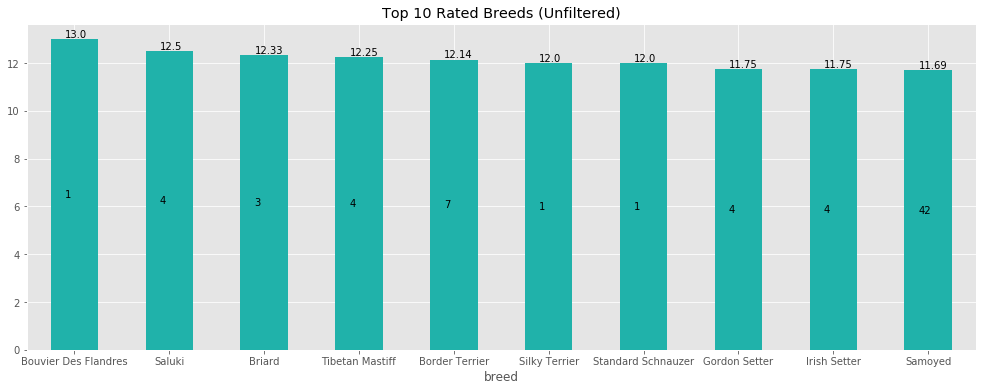

In [92]:
breed_df.sort_values(('rating', 'mean'), ascending=False, inplace=True) # Sort by rating numerator mean

# We reset index to be able to plot with Breed names
breed_df.reset_index()[:10].plot(kind ='bar', x = 'breed', y = ('rating', 'mean'), 
                            figsize=(17,6), color='lightseagreen',
                            title='Top 10 Rated Breeds (Unfiltered)', legend=False)
plt.xticks(rotation = 0)

y = breed_df[('rating', 'mean')].values
z = breed_df[('rating', 'frequency')].values
x = np.arange(0,10,1)

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.1, yy, yy, va='bottom') # breed average rating
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

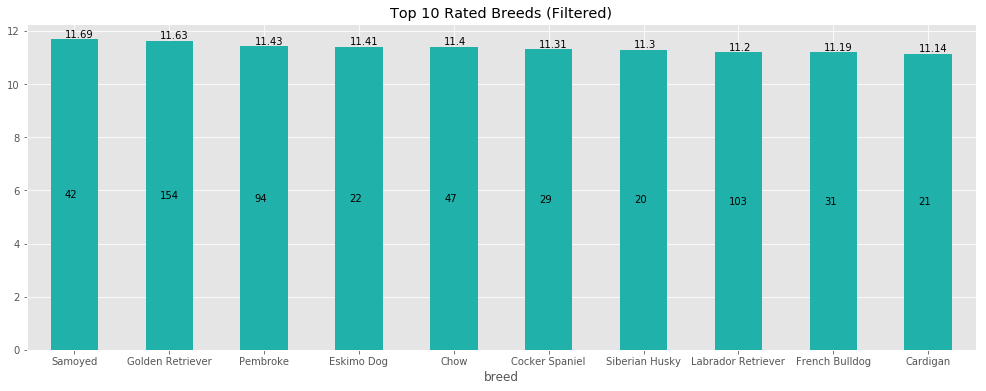

In [93]:
breed_filtered.reset_index()[:10].plot(kind ='bar', x = 'breed', y = ('rating', 'mean'), 
                                    figsize=(17,6), color='lightseagreen',
                                    title='Top 10 Rated Breeds (Filtered)', legend=False)
plt.xticks(rotation = 0)

y = breed_filtered[('rating', 'mean')].values
z = breed_filtered[('rating', 'frequency')].values
x = np.arange(0,10,1)

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.1, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

We can see that without filtering, the Breed with the highest average rating is Bouives Des Flanderes which occurs only once. While the highest rated breed after filtering is Samoyed which happens to be the lowest rating of the Top 10 for unfiltered data. Golden Retriever which happens to be the most commonly tweeted dog is the second highest rated dog for our filtered data. 5 of our most common breeds within the time frame of our entire data also happen to be among the Top 10 rated breeds, after filtering.

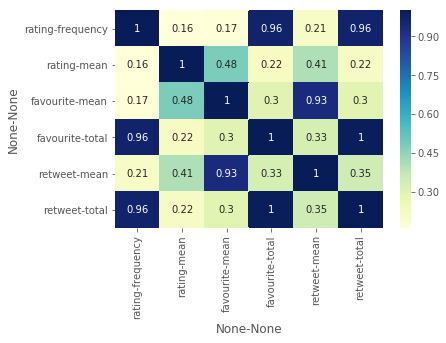

In [94]:
# correlation map for all breeds
sns.heatmap(breed_df.corr(), cmap="YlGnBu", annot=True); 

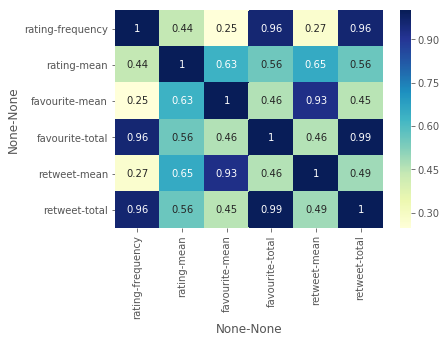

In [95]:
# correlation map for filtered breeds
sns.heatmap(breed_filtered.corr(), cmap="YlGnBu", annot=True);

* There seems to be very obvious differences in the correlation coefficient between columns for our filtered and unfiltered breed dataframes.  
* Rating Frequency which is actually Breed frequency has a strong correlation with the Total favourites and total retweet in both dataframes, this makes shows that the more a breed occurs, the more retweets and favourites it gets.  
* Rating mean which represents average rating of a breed, in our filtered data we see stronger correlation with the favourite mean and retweet mean than we see in the unfiltered data. The more popular a breed is, about 65% of the time, its average tweet engagement(favourites and retweet) will be high if its average rating is also high.  
* The average number of likes(Favourite) a breed gets is strongly tied to the average number of retweets a breed gets, regardless of it is a common breed or not. This also applies to the total number of likes and retweets a breed gets, they are strongly correlated for both dataframes.  

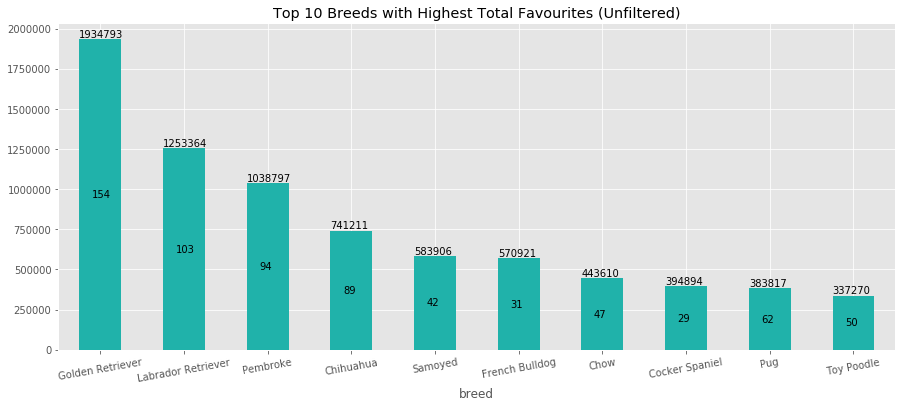

In [96]:
breed_df.sort_values(('favourite', 'total'), ascending=False, inplace=True)
breed_df[:10].reset_index().plot(kind ='bar', y = ('favourite','total'),  x = 'breed' , 
                                figsize=(15,6), color='lightseagreen',
                                title='Top 10 Breeds with Highest Total Favourites (Unfiltered)', legend=False)
plt.xticks(rotation = 10)

y = breed_df[:10][('favourite', 'total')].values
x = np.arange(0,10,1)
z = breed_df[('rating', 'frequency')].values

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.25, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

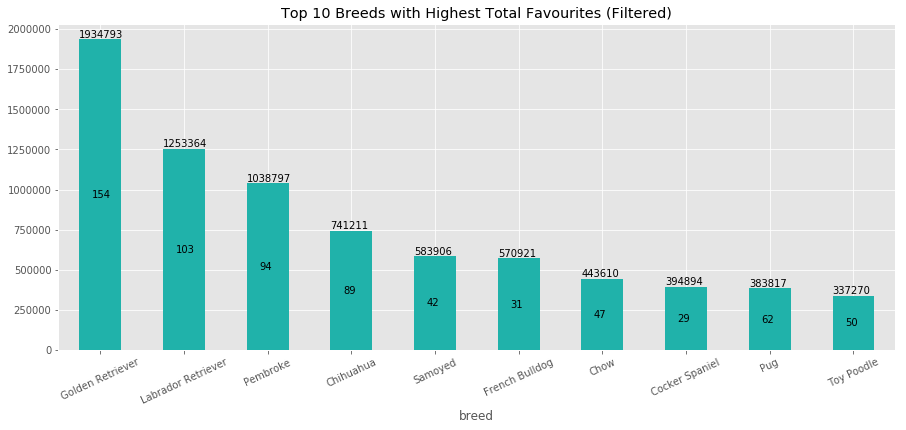

In [97]:
breed_filtered.sort_values(('favourite', 'total'), ascending=False, inplace=True)
breed_filtered[:10].reset_index().plot(kind ='bar', y = ('favourite','total'),  x = 'breed' , 
                                figsize=(15,6), color='lightseagreen',
                                title='Top 10 Breeds with Highest Total Favourites (Filtered)', legend=False)
plt.xticks(rotation = 25)

y = breed_filtered[:10][('favourite', 'total')].values.round(2)
x = np.arange(0,10,1)
z = breed_filtered[('rating', 'frequency')].values

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.25, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

The breeds with the highest number of likes are the same for our filtered and unfiltered dataframes. This satisfies are pervious observation from the correlation heat map, that breed frequency ties strongly with number of likes a breed will get.

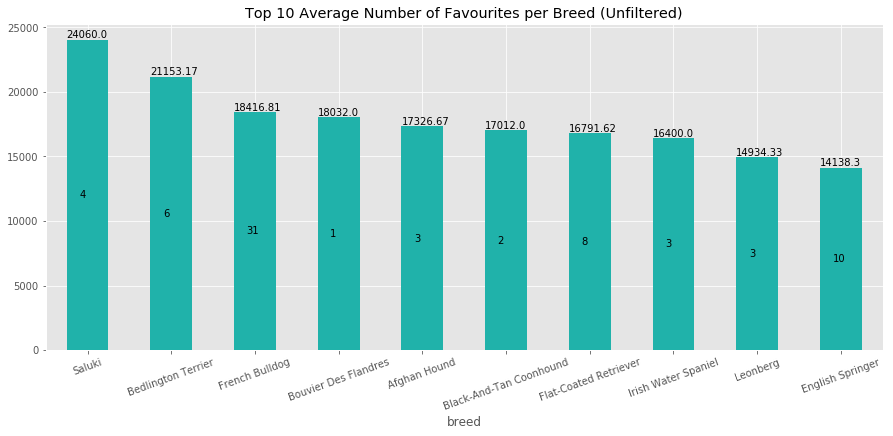

In [98]:
breed_df.sort_values(('favourite', 'mean'), ascending=False, inplace=True)
breed_df[:10].reset_index().plot(kind ='bar', y = ('favourite','mean'),  x = 'breed' , 
                                figsize=(15,6), color='lightseagreen',
                                title='Top 10 Average Number of Favourites per Breed (Unfiltered)', legend=False)
plt.xticks(rotation = 20)

y = breed_df[:10][('favourite', 'mean')].values
x = np.arange(0,10,1)
z = breed_df[('rating', 'frequency')].values

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.25, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

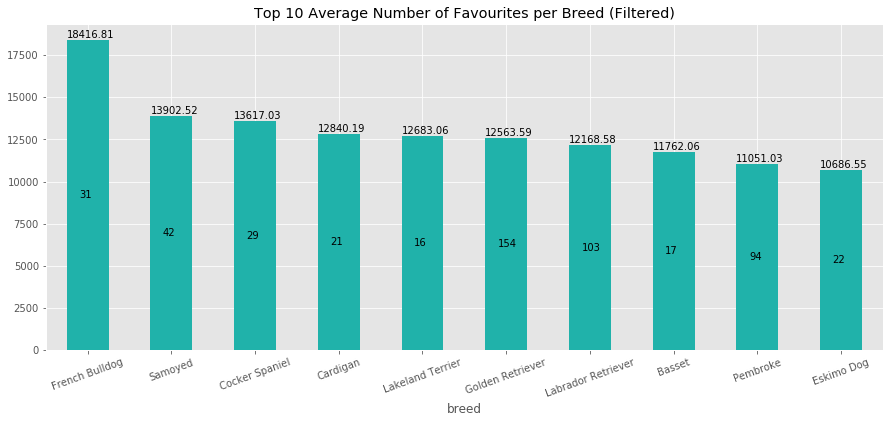

In [99]:
breed_filtered.sort_values(('favourite', 'mean'), ascending=False, inplace=True)
breed_filtered[:10].reset_index().plot(kind ='bar', y = ('favourite','mean'),  x = 'breed' , 
                                figsize=(15,6), color='lightseagreen',
                                title='Top 10 Average Number of Favourites per Breed (Filtered)', legend=False)
plt.xticks(rotation = 20)

y = breed_filtered[:10][('favourite', 'mean')].values
x = np.arange(0,10,1)
z = breed_filtered[('rating', 'frequency')].values

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.25, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

Here there are very obvious differences in our average likes visualisations for both dataframes. Only the French Bulldog is present in our filtered and unfiltered breed dataframes.  
The French Bulldog seems to be the most popular dog with the highest average number likes since it is present in both our visualisations. The Saluki while not popular in our dataset, is the most liked breed.

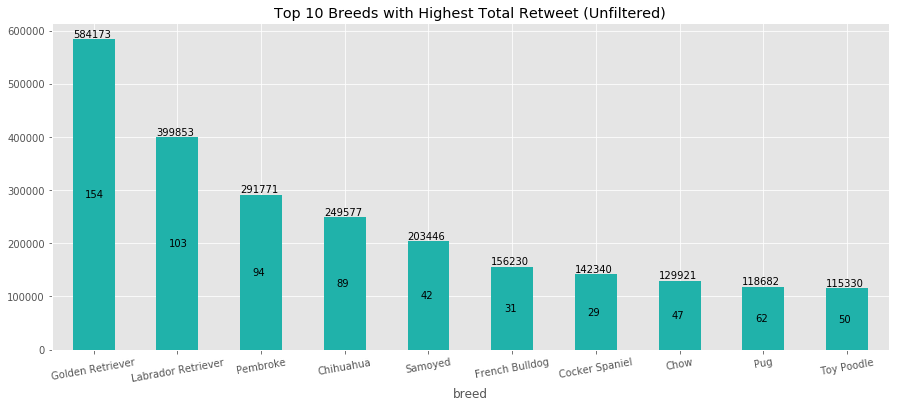

In [100]:
breed_df.sort_values(('retweet', 'total'), ascending=False, inplace=True)
breed_df[:10].reset_index().plot(kind ='bar', y = ('retweet','total'),  x = 'breed' , 
                                figsize=(15,6), color='lightseagreen',
                                title='Top 10 Breeds with Highest Total Retweet (Unfiltered)', legend=False)
plt.xticks(rotation = 10)

y = breed_df[:10][('retweet', 'total')].values
x = np.arange(0,10,1)
z = breed_df[('rating', 'frequency')].values

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.25, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

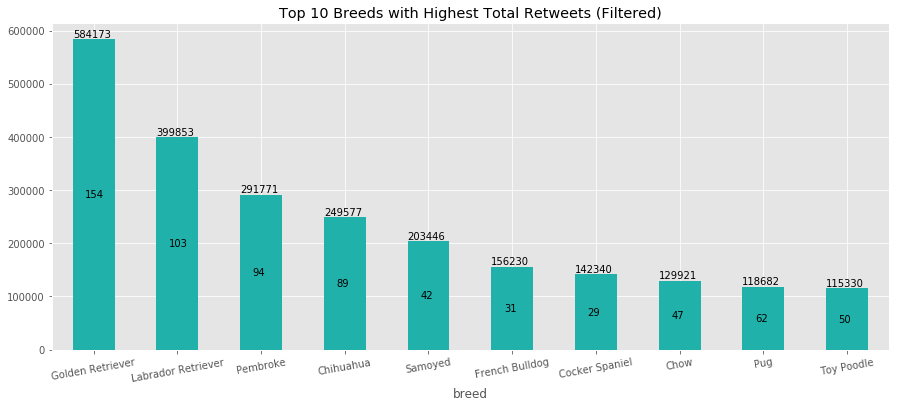

In [101]:
breed_filtered.sort_values(('retweet', 'total'), ascending=False, inplace=True)
breed_filtered[:10].reset_index().plot(kind ='bar', y = ('retweet','total'),  x = 'breed' , 
                                figsize=(15,6), color='lightseagreen',
                                title='Top 10 Breeds with Highest Total Retweets (Filtered)', legend=False)
plt.xticks(rotation = 10)

y = breed_filtered[:10][('retweet', 'total')].values.round(2)
x = np.arange(0,10,1)
z = breed_filtered[('rating', 'frequency')].values

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.25, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

As seen with Breeds with the highest number of favourites, the breeds with the highets number of retweets are the same for our filtered and unfiltered data.  
The breeds with the highest number of favourites are also the same as the breeds with the highest number of likes as seen in our correlation heat map.

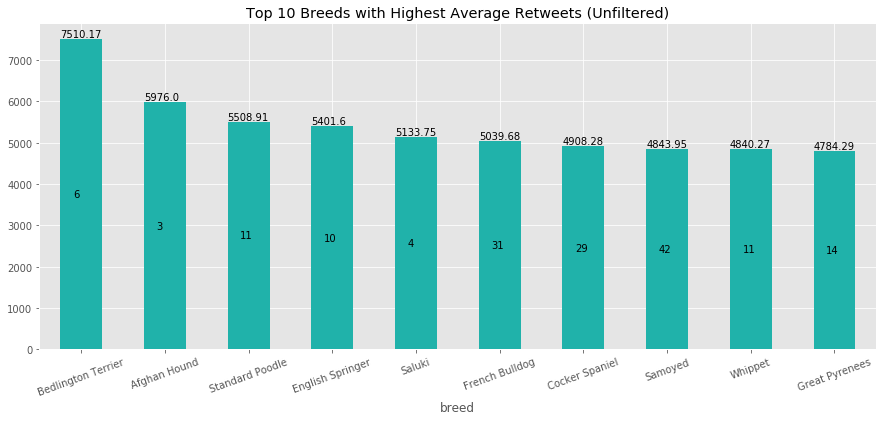

In [102]:
breed_df.sort_values(('retweet', 'mean'), ascending=False, inplace=True)
breed_df[:10].reset_index().plot(kind ='bar', y = ('retweet','mean'),  x = 'breed' , 
                                figsize=(15,6), color='lightseagreen',
                                title='Top 10 Breeds with Highest Average Retweets (Unfiltered)', legend=False)
plt.xticks(rotation = 20)

y = breed_df[:10][('retweet', 'mean')].values
x = np.arange(0,10,1)
z = breed_df[('rating', 'frequency')].values

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.25, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

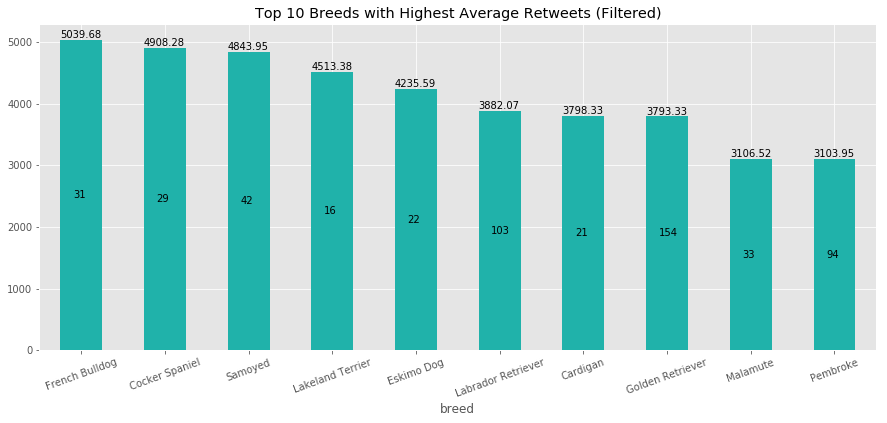

In [103]:
breed_filtered.sort_values(('retweet', 'mean'), ascending=False, inplace=True)
breed_filtered[:10].reset_index().plot(kind ='bar', y = ('retweet','mean'),  x = 'breed' , 
                                figsize=(15,6), color='lightseagreen',
                                title='Top 10 Breeds with Highest Average Retweets (Filtered)', legend=False)
plt.xticks(rotation = 20)

y = breed_filtered[:10][('retweet', 'mean')].values
x = np.arange(0,10,1)
z = breed_filtered[('rating', 'frequency')].values

# Add text value for each breed:
for xx, yy, zz in zip(x, y, z):
    plt.text(xx-0.25, yy, yy, va='bottom')
    plt.text(xx-0.1, yy*0.5, zz , va='center') # breed frequency

* Only 5 breeds in the previous top 10 average number of favourites are also present in the top 10 breeds with the highest number of retweets.
* Only the French Bulldog, Cockier Spaniel and Samoyed breeds from our unfiltered data for Highest average retweets are also present in the Top breeds with the highest total favourites and retweets.  
* French Bulldog, Cockier Spaniel and Samoyed are the most retweeted breeds on average in our filtered data. They also are one of the most retweeted breeds on average in our unfiltered dataset.
* French Bulldog, Cockier Spaniel, Samoyed, Golden Retriever, Labrador Retriever, Pembroke are the only popular breeds that with high total number of retweets to also have high average number of retweets.

In [104]:
# concatenate texts in texts column into one string
texts = ' '.join(tweets['text']) 

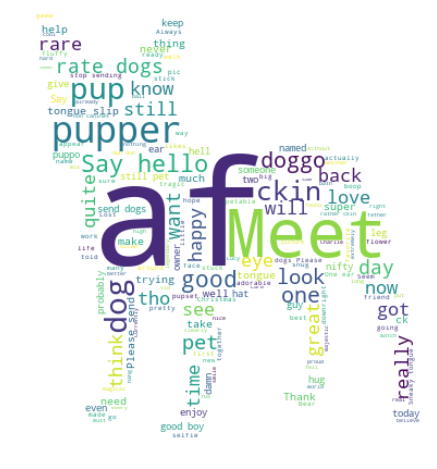

In [108]:
# create a mask to use for our word cloud
dog_mask = np.array(Image.open("dog.jpg"))

stopwords = set(STOPWORDS)
wc = WordCloud(background_color='white', stopwords=stopwords,  max_font_size=200,
              mask = dog_mask, height=3000, width=3000) # 

wc.generate(texts)

plt.figure(figsize=(20,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Insights

1. The handler of the this twitter account like to use the abbreviation "af" a lot. WHich means he/she liked to emphasize their description or sentiments for any dog they were rating.
2. Of the four different classisfication of dogs, Pupper was the handlers favourite description for dogs. From the 'dogtionary', these dogs are small or young dogs.
3. In the time period under consideration, the maximum number of characters for a tweet was 140. Therefore, the handler used a lot of long tweets, between 100 and 140 characters for most of their tweets.
4. The handler was very generous with ratings, giving most dogs a numerator 10 or more.
5. The two most popular breeds rated, were both Retrievers. If people sent their dog's pictures to be rated, most of the dogs owners who are aware of the account owned Retrievers (Golden and Labrador). If the handler found the pictures on their own, is it easier to find pictures of retrievers than other breeds ?
6. It appears the handler has a bias towards the Golden Retriever, as it is also closely the dog with second highest rating for popular dogs. The Labrador Retriever is also in the top 10 for popular dogs with the highest ratings.
7. The most popular dogs also had the most total engagements in terms of Favourites and retweets.
8. Followers of the accounts seemed to have lots of love for the French Bulldog, Cocker Spaniel and the Samoyed as they were the most popular dogs that received the most likes or retweets on average.
9. The Beddington Terrier and Saluki breeds are probably the breed followers of the account liked the most. They received the most total engagements on average even with their lack of popularity. (All though these engagement values could be skewed due to just one of their pictures receiving very very large number of engagements.)